# Step 1: Setup


สำหรับ Dataset ที่ใช้จากแหล่งข้อมูลนี้มีทั้งหมด 4 dataset โดยเราเลือกใช้ city_hour.csv เนื่องจากข้อมูลมีจำนวนมากถึง 707875 rows

### Import libraries & Load dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier #Model: Decision Tree
from xgboost import XGBClassifier #Model: XGBoost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #Evaluation

import kagglehub

In [37]:
# Load dataset
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")
city_hour = pd.read_csv(path+'/city_hour.csv')

### Studying dataset
ทำความรู้จัก Dataset ที่เราจะนำไปใช้งานก่อน

In [38]:
city_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        707875 non-null  object 
 1   Datetime    707875 non-null  object 
 2   PM2.5       562787 non-null  float64
 3   PM10        411138 non-null  float64
 4   NO          591243 non-null  float64
 5   NO2         590753 non-null  float64
 6   NOx         584651 non-null  float64
 7   NH3         435333 non-null  float64
 8   CO          621358 non-null  float64
 9   SO2         577502 non-null  float64
 10  O3          578667 non-null  float64
 11  Benzene     544229 non-null  float64
 12  Toluene     487268 non-null  float64
 13  Xylene      252046 non-null  float64
 14  AQI         578795 non-null  float64
 15  AQI_Bucket  578795 non-null  object 
dtypes: float64(13), object(3)
memory usage: 86.4+ MB


In [39]:
city_hour

City             Datetime  PM2.5   PM10    NO    NO2    NOx  \
0           Ahmedabad  2015-01-01 01:00:00    NaN    NaN  1.00  40.01  36.37   
1           Ahmedabad  2015-01-01 02:00:00    NaN    NaN  0.02  27.75  19.73   
2           Ahmedabad  2015-01-01 03:00:00    NaN    NaN  0.08  19.32  11.08   
3           Ahmedabad  2015-01-01 04:00:00    NaN    NaN  0.30  16.45   9.20   
4           Ahmedabad  2015-01-01 05:00:00    NaN    NaN  0.12  14.90   7.85   
...               ...                  ...    ...    ...   ...    ...    ...   
707870  Visakhapatnam  2020-06-30 20:00:00   9.50  36.00  2.75  25.57  15.85   
707871  Visakhapatnam  2020-06-30 21:00:00  17.25  49.25  3.62  33.20  20.62   
707872  Visakhapatnam  2020-06-30 22:00:00  36.00  71.00  2.20  30.80  18.20   
707873  Visakhapatnam  2020-06-30 23:00:00  15.75  63.00  1.02  28.90  16.00   
707874  Visakhapatnam  2020-07-01 00:00:00  15.00  66.00  0.40  26.85  14.05   

         NH3    CO     SO2      O3  Benzene  Toluene  Xylene   AQI  \
0        NaN  1.00  122.07     NaN      0.0      0.0     0.0   NaN   
1        NaN  0.02   85.90     NaN      0.0      0.0     0.0   NaN   
2        NaN  0.08   52.83     NaN      0.0      0.0     0.0   NaN   
3        NaN  0.30   39.53  153.58      0.0      0.0     0.0   NaN   
4        NaN  0.12   32.63     NaN      0.0      0.0     0.0   NaN   
...      ...   ...     ...     ...      ...      ...     ...   ...   
707870  4.57  0.62     NaN   27.75      NaN      NaN     NaN  51.0   
707871  3.78  0.76    2.02   25.58      NaN      NaN     NaN  51.0   
707872  3.67  0.58    1.77   26.15      NaN      NaN     NaN  50.0   
707873  3.80  0.49    0.75   15.82      NaN      NaN     NaN  50.0   
707874  5.20  0.59    2.10   17.05      NaN      NaN     NaN  50.0   

          AQI_Bucket  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
707870  Satisfactory  
707871  Satisfactory  
707872          Good  
707873          Good  
707874          Good  

[707875 rows x 16 columns]

จากจำนวนข้อมูลทั้งหมด 707,875 rows มีข้อมูลที่มี class label หรือ target (AQI และ/หรือ AQU_Bucket) แค่ 578,795 rows แสดงว่ามี 129,080 rows ที่ไม่มี target label

# Step 2: Preprocessing

## Cleaning (Handle Missing Data)
ทำความสะอาดข้อมูล ดรอปฟีเจอร์ที่ไม่สำคัญ และแถวข้อมูลที่ไม่มี class label

In [40]:
# ทำการ drop row ที่ target label เป็น null เพราะไม่สามารถนำไปใช้วัดผลว่าโมเดลทำนายถูกหรือไม่
dataset = city_hour.dropna(subset=['AQI', 'AQI_Bucket'])

dataset.info()

# ตรวจสอบ null values หรือ missing values อีกครั้งหนึ่งเพื่อ cleaning
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 578795 entries, 680 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        578795 non-null  object 
 1   Datetime    578795 non-null  object 
 2   PM2.5       547760 non-null  float64
 3   PM10        399932 non-null  float64
 4   NO          557314 non-null  float64
 5   NO2         556528 non-null  float64
 6   NOx         526889 non-null  float64
 7   NH3         414801 non-null  float64
 8   CO          549649 non-null  float64
 9   SO2         545737 non-null  float64
 10  O3          545423 non-null  float64
 11  Benzene     482430 non-null  float64
 12  Toluene     429794 non-null  float64
 13  Xylene      207095 non-null  float64
 14  AQI         578795 non-null  float64
 15  AQI_Bucket  578795 non-null  object 
dtypes: float64(13), object(3)
memory usage: 75.1+ MB


City               0
Datetime           0
PM2.5          31035
PM10          178863
NO             21481
NO2            22267
NOx            51906
NH3           163994
CO             29146
SO2            33058
O3             33372
Benzene        96365
Toluene       149001
Xylene        371700
AQI                0
AQI_Bucket         0
dtype: int64

In [41]:
# เราจะพบว่า Xylene มีข้อมูลเป็น null ถึง 371,700 ซึ่งถือว่าเกิน 1/2 ของ dataset ของเราเลย ดังนั้นเราจะ drop feature นี้ออกไป
# นอกจากนี้ เราจะขอ drop ในส่วนของ Datetime ออกไปด้วยเช่นกัน เพราะไม่ได้สำคัญกับการ train
dataset = dataset.drop(['Datetime', 'Xylene'], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 578795 entries, 680 to 707874
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        578795 non-null  object 
 1   PM2.5       547760 non-null  float64
 2   PM10        399932 non-null  float64
 3   NO          557314 non-null  float64
 4   NO2         556528 non-null  float64
 5   NOx         526889 non-null  float64
 6   NH3         414801 non-null  float64
 7   CO          549649 non-null  float64
 8   SO2         545737 non-null  float64
 9   O3          545423 non-null  float64
 10  Benzene     482430 non-null  float64
 11  Toluene     429794 non-null  float64
 12  AQI         578795 non-null  float64
 13  AQI_Bucket  578795 non-null  object 
dtypes: float64(12), object(2)
memory usage: 66.2+ MB


## Studying Data

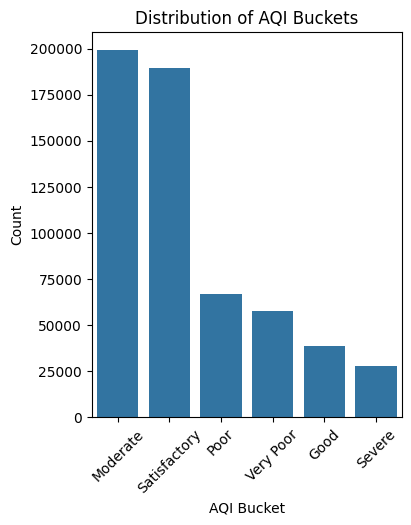

In [42]:
aqi_bucket_counts = dataset['AQI_Bucket'].value_counts()

# พล็อตกราฟเพื่อดูจำนวนสมาชิกในแต่ละ Class
plt.figure(figsize=(4, 5))
sns.countplot(x='AQI_Bucket', data=dataset, order=aqi_bucket_counts.index)
plt.title('Distribution of AQI Buckets')
plt.xlabel('AQI Bucket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

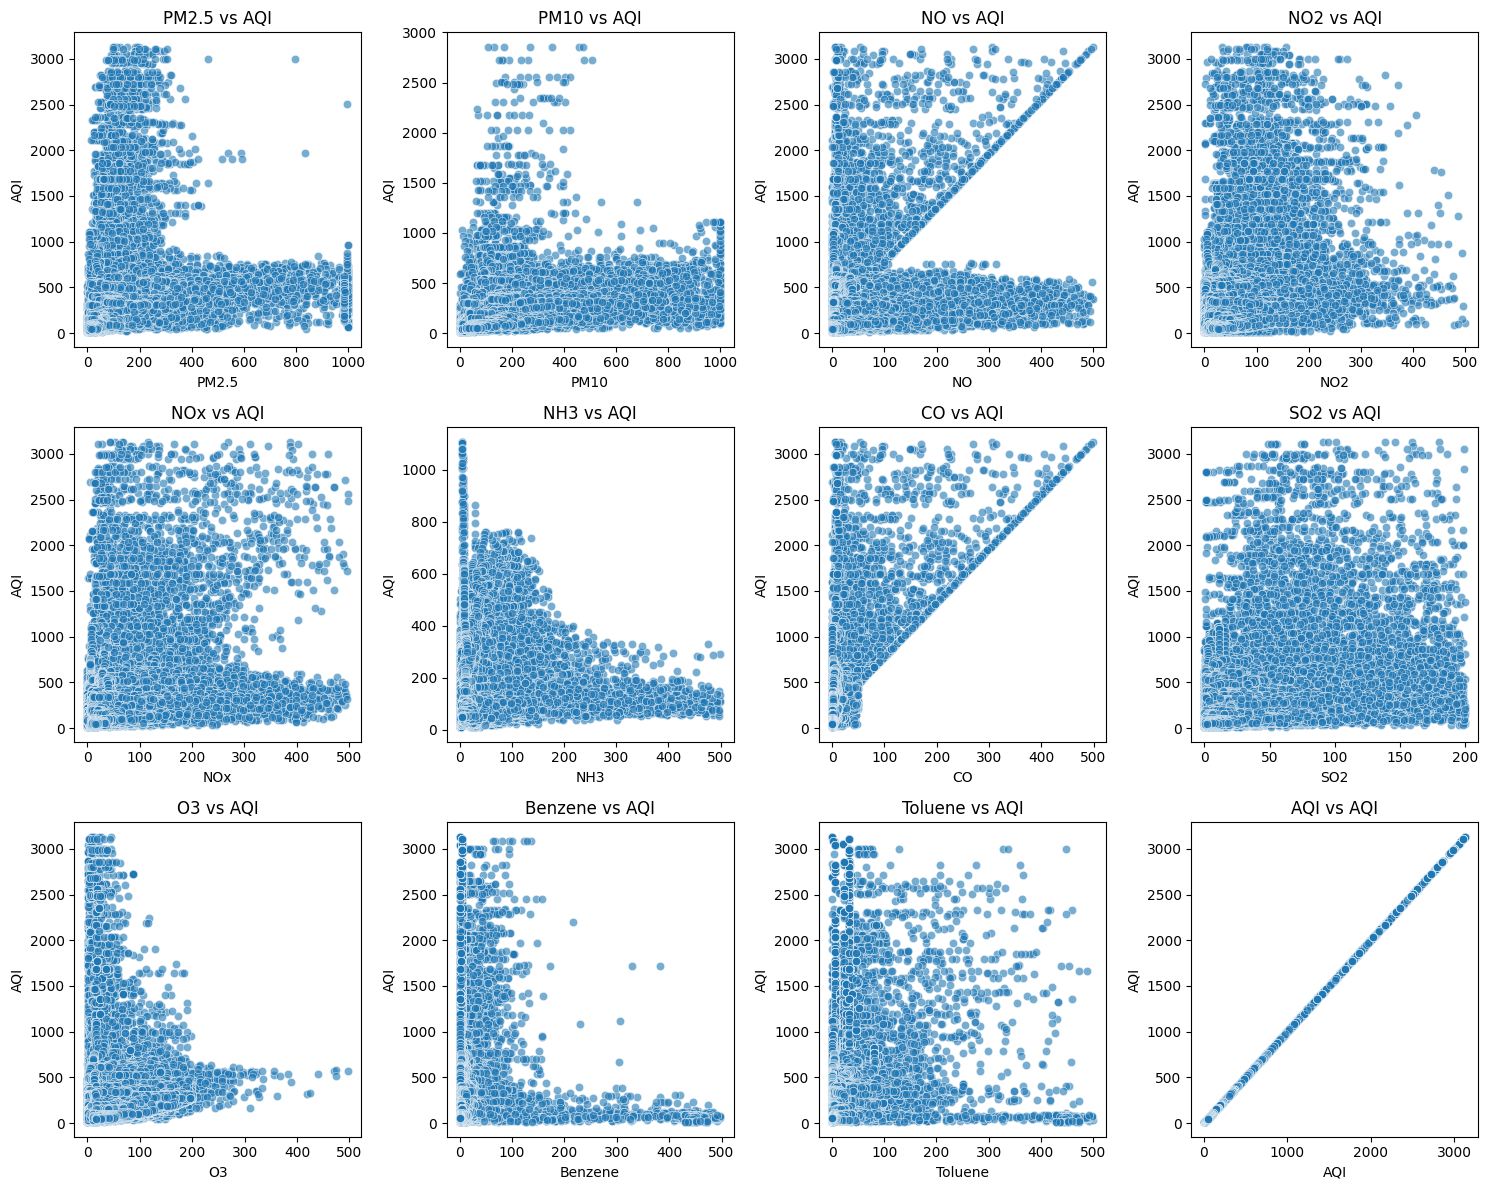

In [43]:
# กำหนดคอลัมน์ที่ต้องการวิเคราะห์
columns_to_visualize = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

# กำหนดจำนวนแถวและคอลัมน์ใน grid layout
n_cols = 4  # จำนวนคอลัมน์ต่อแถว
n_rows = (len(columns_to_visualize) + n_cols - 1) // n_cols  # คำนวณจำนวนแถว

# สร้างกราฟแบบ grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # ขนาดรูปทั้งหมด

for i, col in enumerate(columns_to_visualize):
    row, col_pos = divmod(i, n_cols)
    sns.scatterplot(data=dataset, x=col, y='AQI', ax=axes[row, col_pos], alpha=0.6)
    axes[row, col_pos].set_title(f'{col} vs AQI')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('AQI')

# ซ่อน axes ที่เหลือ
for j in range(i + 1, n_rows * n_cols):
    row, col_pos = divmod(j, n_cols)
    axes[row, col_pos].axis('off')

plt.tight_layout()
plt.show()

## Filled Missing Data (ทดลองทำ 3 วิธี)

In [44]:
# รายชื่อคอลัมน์ที่ต้องการเติมค่าด้วยค่าเฉลี่ย (mean)
columns_to_fill = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

### แบบที่ 1: ใช้ Class label ในการจัดกลุ่มข้อมูล (Filled 0) <= เราจะยึดวิธีนี้เป็นหลัก
- เนื่องจากข้อมูลมีการแบ่งคลาสคำตอบโดยใช้ AQI_Bucket อยู่แล้ว และ AQI_Bucket ก็สัมพันธ์กับฟีเจอร์แต่ละตัว
- ดังนั้น เราจึงใช้ AQI_Bucket จัดกลุ่ม แล้วหาค่าเฉลี่ย (mean) ของแต่ละกลุ่ม fill ลงไปในช่องที่เป็น null และเป็น 0

In [45]:
# สร้างสำเนาของ dataset เพื่อเก็บผลลัพธ์
filled_dataset_1 = dataset.copy()

# ทำการ fill ช่องข้อมูลที่เป็น 0 และ NaN ด้วย mean ของแต่ละกลุ่ม โดยใช้ AQI_Bucket ซึ่งเป็น Target class สำหรับการแบ่งกลุ่ม
for col in columns_to_fill:
    filled_dataset_1[col] = filled_dataset_1.groupby('AQI_Bucket')[col].transform(
        lambda group: group.replace(0, None).fillna(group.mean())
    )

filled_dataset_1.isnull().sum()

<ipython-input-45-8011aa0a05c1>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda group: group.replace(0, None).fillna(group.mean())
<ipython-input-45-8011aa0a05c1>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda group: group.replace(0, None).fillna(group.mean())
<ipython-input-45-8011aa0a05c1>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

### แบบที่ 2: ใช้ Class label ในการจัดกลุ่มข้อมูล (ไม่ Filled 0)

In [46]:
# สร้างสำเนาของ dataset เพื่อเก็บผลลัพธ์
filled_dataset_2 = dataset.copy()

# ทำการ fill ช่องข้อมูลที่เป็น 0 และ NaN ด้วย mean ของแต่ละกลุ่ม โดยใช้ AQI_Bucket ซึ่งเป็น Target class สำหรับการแบ่งกลุ่ม
for col in columns_to_fill:
    filled_dataset_2[col] = filled_dataset_1.groupby('AQI_Bucket')[col].transform(
        lambda group: group.replace(None).fillna(group.mean())
    )

filled_dataset_1.isnull().sum()

<ipython-input-46-8bd1f092a7d1>:7: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-46-8bd1f092a7d1>:7: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-46-8bd1f092a7d1>:7: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-46-8bd1f092a7d1>:7: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new value

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

### แบบที่ 3: ใช้ City และ Class label ในการจับกลุ่มข้อมูลร่วมกัน (Filled 0)

In [47]:
filled_dataset_3 = dataset.copy()

for col in columns_to_fill:
    filled_dataset_3[col] = filled_dataset_3.groupby(['City', 'AQI_Bucket'])[col].transform(
        lambda group: group.replace(0, None).fillna(group.mean())
    )
    # If still missing, fill by AQI_Bucket only (เนื่องจากมีหลาย City ที่พบว่า ข้อมูลบาง features แหว่งหายไปเลย เพื่อความชัวร์เราจึง fill อีกครั้งหนึ่งด้วย AQI_Bucket)
    filled_dataset_3[col] = filled_dataset_3.groupby('AQI_Bucket')[col].transform(
        lambda group: group.fillna(group.mean())
    )

filled_dataset_3.isnull().sum()

<ipython-input-47-ebda9cfb884a>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda group: group.replace(0, None).fillna(group.mean())
<ipython-input-47-ebda9cfb884a>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda group: group.replace(0, None).fillna(group.mean())
<ipython-input-47-ebda9cfb884a>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

### แบบที่ 4: ใช้ City และ Class label ในการจับกลุ่มข้อมูลร่วมกัน (ไม่ Filled 0)

In [48]:
filled_dataset_4 = dataset.copy()

for col in columns_to_fill:
    filled_dataset_4[col] = filled_dataset_4.groupby(['City', 'AQI_Bucket'])[col].transform(
        lambda group: group.replace(None).fillna(group.mean())
    )
    # If still missing, fill by AQI_Bucket only (เนื่องจากมีหลาย City ที่พบว่า ข้อมูลบาง features แหว่งหายไปเลย เพื่อความชัวร์เราจึง fill อีกครั้งหนึ่งด้วย AQI_Bucket)
    filled_dataset_4[col] = filled_dataset_4.groupby('AQI_Bucket')[col].transform(
        lambda group: group.fillna(group.mean())
    )

filled_dataset_4.isnull().sum()

<ipython-input-48-f7fcafb67bba>:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-48-f7fcafb67bba>:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-48-f7fcafb67bba>:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  lambda group: group.replace(None).fillna(group.mean())
<ipython-input-48-f7fcafb67bba>:5: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new value

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

### วิธีใหม่ (mean by city) --- วิธีนี้ไม่ได้ใช้เพราะผิดพลาด

In [49]:
# # สร้างสำเนาของ dataset เพื่อเก็บผลลัพธ์
# filled_dataset = dataset.copy()

# # รายชื่อคอลัมน์ที่ต้องการเติมค่าด้วยค่าเฉลี่ย (mean)
# columns_to_fill = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

# # ทำการ fill ช่องข้อมูลที่เป็น 0 และ NaN ด้วย mean ของแต่ละกลุ่ม โดยใช้ AQI_Bucket ซึ่งเป็น Target class สำหรับการแบ่งกลุ่ม
# for col in columns_to_fill:
#     filled_dataset[col] = filled_dataset.groupby(['City', 'AQI_Bucket'])[col].transform(
#         lambda group: group.replace(0, None).fillna(group.mean())
#     )

In [50]:
# filled_dataset

In [51]:
# # เลือกค่าที่เป็น NaN ในคอลัมน์ NH3 สำหรับ Ahmedabad
# nan_rows = filled_dataset[(filled_dataset['City'] == 'Ahmedabad') & (filled_dataset['NH3'].isna())]

# # เติมค่า NaN ใน NH3 ด้วย mean ของ Mumbai โดยแยกตาม AQI_Bucket
# for index, row in nan_rows.iterrows():
#     city = 'Mumbai'
#     aqi_bucket = row['AQI_Bucket']

#     # คำนวณ mean ของ Mumbai สำหรับ AQI_Bucket ที่ตรงกัน
#     mean_value = filled_dataset[
#         (filled_dataset['City'] == city) &
#         (filled_dataset['AQI_Bucket'] == aqi_bucket)
#     ]['NH3'].mean()

#     # เติมค่า mean ลงใน Ahmedabad
#     filled_dataset.loc[index, 'NH3'] = mean_value

# # ตรวจสอบผลลัพธ์
# print(filled_dataset[(filled_dataset['City'] == 'Ahmedabad') & (filled_dataset['NH3'].isna())])


In [52]:
# filled_dataset.isnull().sum()

In [53]:
# # ทำการ fill ช่องข้อมูลที่เป็น 0 และ NaN ด้วย mean ของแต่ละกลุ่ม โดยใช้ AQI_Bucket ซึ่งเป็น Target class สำหรับการแบ่งกลุ่ม
# for col in columns_to_fill:
#     filled_dataset[col] = filled_dataset.groupby('AQI_Bucket')[col].transform(
#         lambda group: group.replace(0, None).fillna(group.mean())
#     )

In [54]:
# filled_dataset

### Study dataset after cleaning (ในกรณีนี้เราจะแสดงของแบบที่ 1)

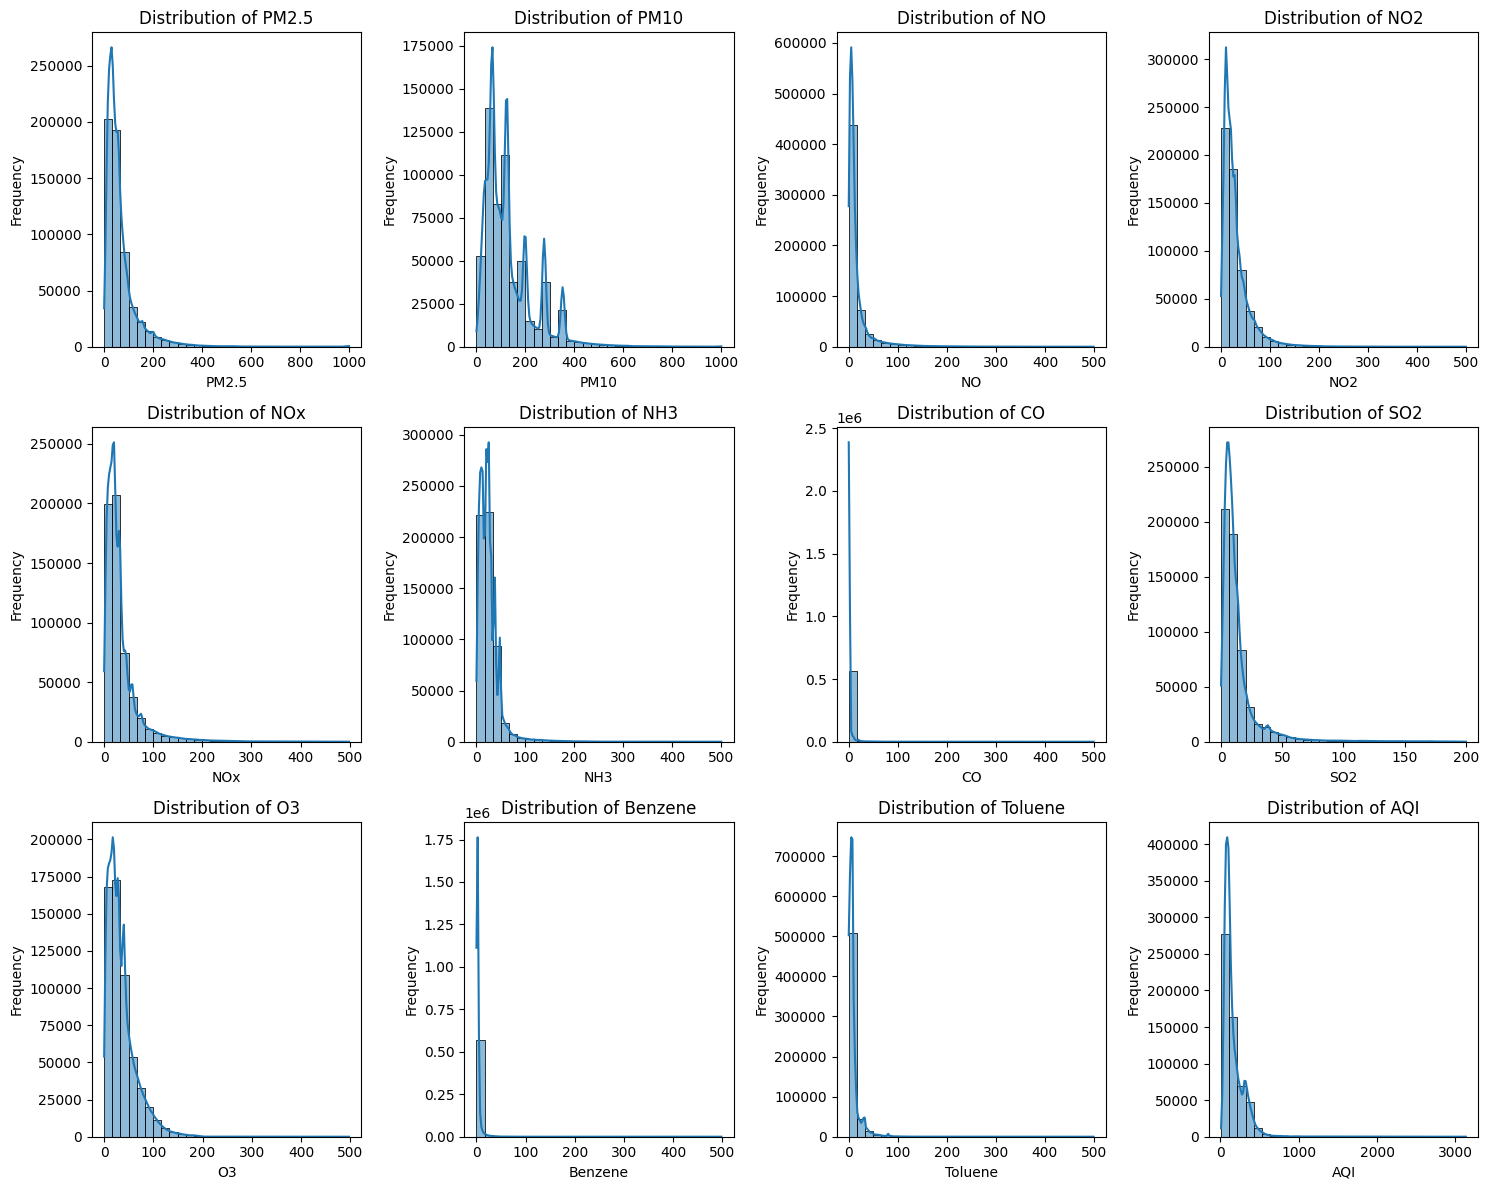

In [55]:
# กำหนดคอลัมน์ที่ต้องการวิเคราะห์
columns_to_visualize = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

# กำหนดจำนวนแถวและคอลัมน์ใน grid layout
n_cols = 4  # จำนวนคอลัมน์ต่อแถว
n_rows = (len(columns_to_visualize) + n_cols - 1) // n_cols  # คำนวณจำนวนแถว

# สร้างกราฟแบบ grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # ขนาดรูปทั้งหมด

# แสดงกราฟในแต่ละช่อง
for i, col in enumerate(columns_to_visualize):
    row, col_pos = divmod(i, n_cols)
    sns.histplot(filled_dataset_1[col], kde=True, bins=30, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

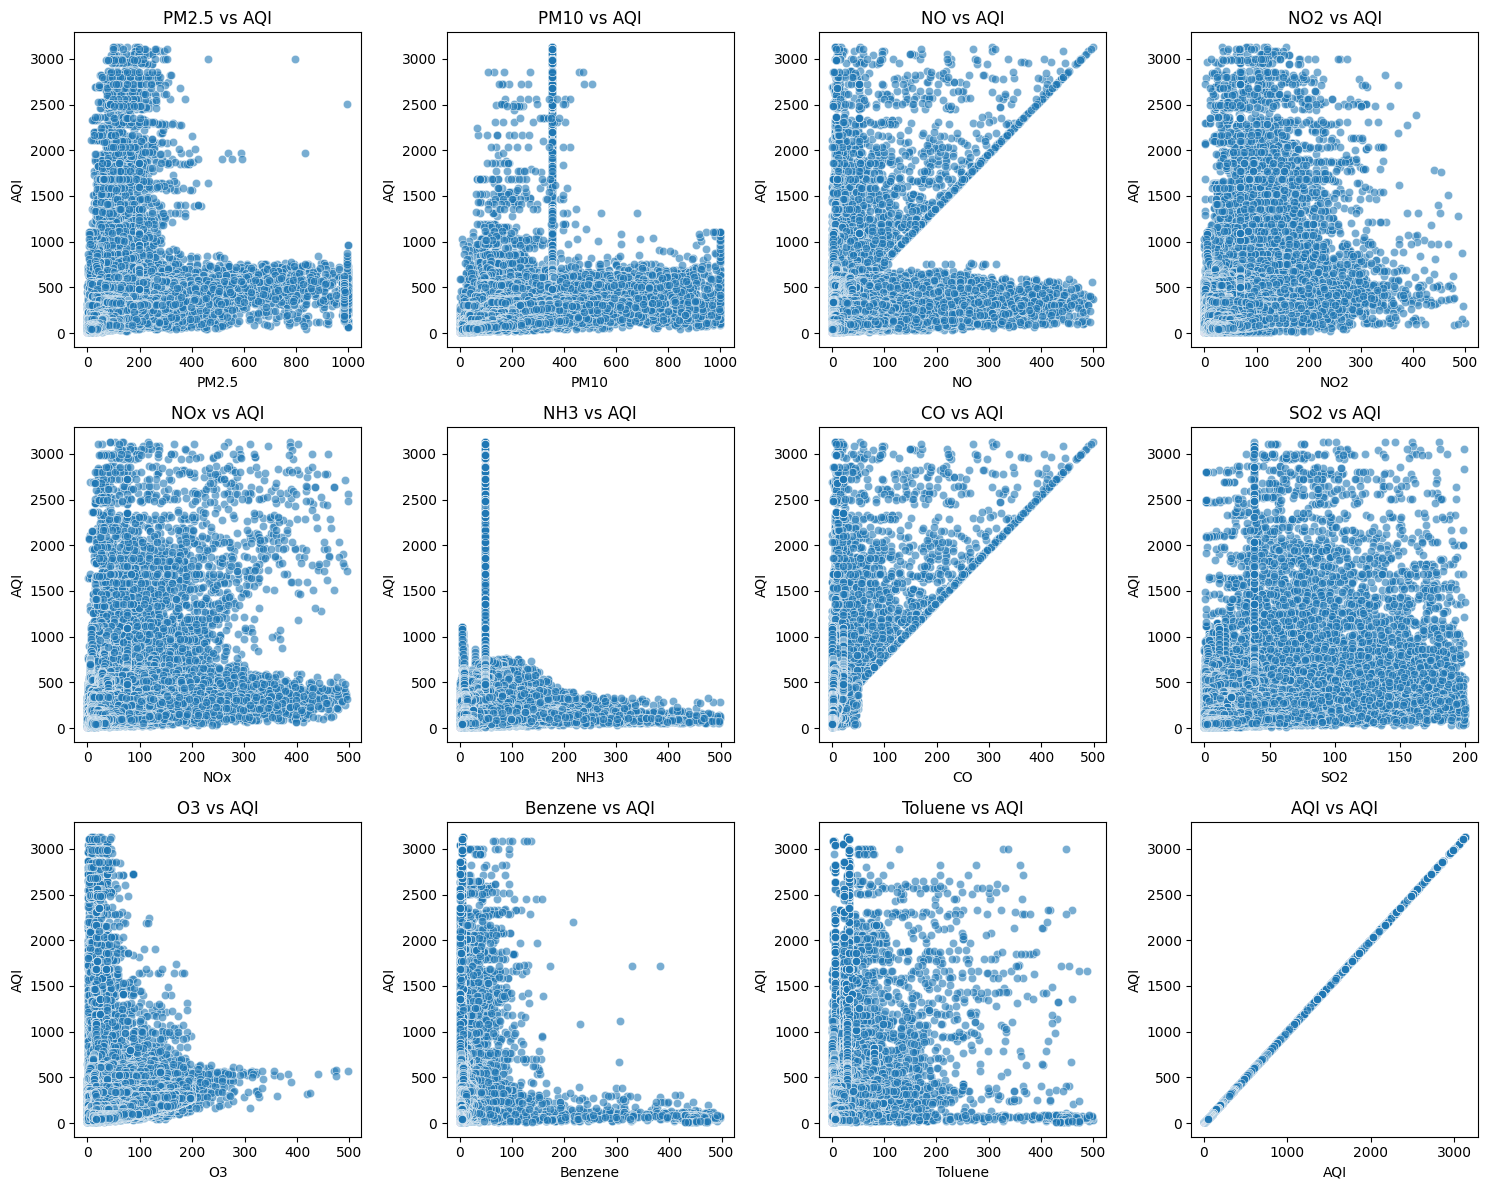

In [56]:
# กำหนดคอลัมน์ที่ต้องการวิเคราะห์
columns_to_visualize = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

# กำหนดจำนวนแถวและคอลัมน์ใน grid layout
n_cols = 4  # จำนวนคอลัมน์ต่อแถว
n_rows = (len(columns_to_visualize) + n_cols - 1) // n_cols  # คำนวณจำนวนแถว

# สร้างกราฟแบบ grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # ขนาดรูปทั้งหมด

# แสดง scatter plot ในแต่ละช่อง
for i, col in enumerate(columns_to_visualize):
    row, col_pos = divmod(i, n_cols)
    sns.scatterplot(data=filled_dataset_1, x=col, y='AQI', ax=axes[row, col_pos], alpha=0.6)
    axes[row, col_pos].set_title(f'{col} vs AQI')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('AQI')

# ซ่อน axes ที่เหลือ
for j in range(i + 1, n_rows * n_cols):
    row, col_pos = divmod(j, n_cols)
    axes[row, col_pos].axis('off')

plt.tight_layout()
plt.show()

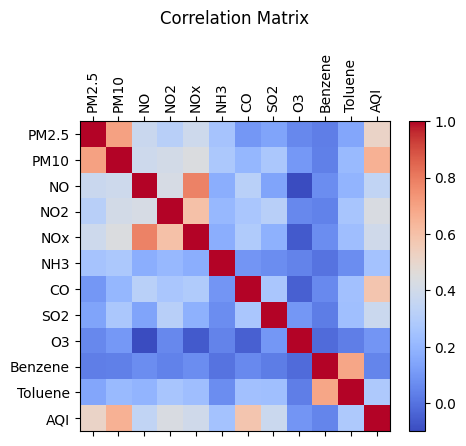

In [57]:
# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข
numerical_dataset = filled_dataset_1.select_dtypes(include=['float64', 'int64'])

# คำนวณ correlation matrix
correlation_matrix = numerical_dataset.corr()

# แสดงผล correlation matrix ด้วย matshow
plt.figure(figsize=(5, 4))  # ปรับขนาดกราฟให้เหมาะสม
plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')  # เพิ่ม colormap
plt.colorbar()  # เพิ่ม legend แสดงระดับค่า correlation
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix", pad=20)
plt.show()

### แอบลองมาดู Scatter plot กับ Heatmap ของ dataset ดั้งเดิมแบบที่ยังไม่ทำการ fill หน่อยซิ

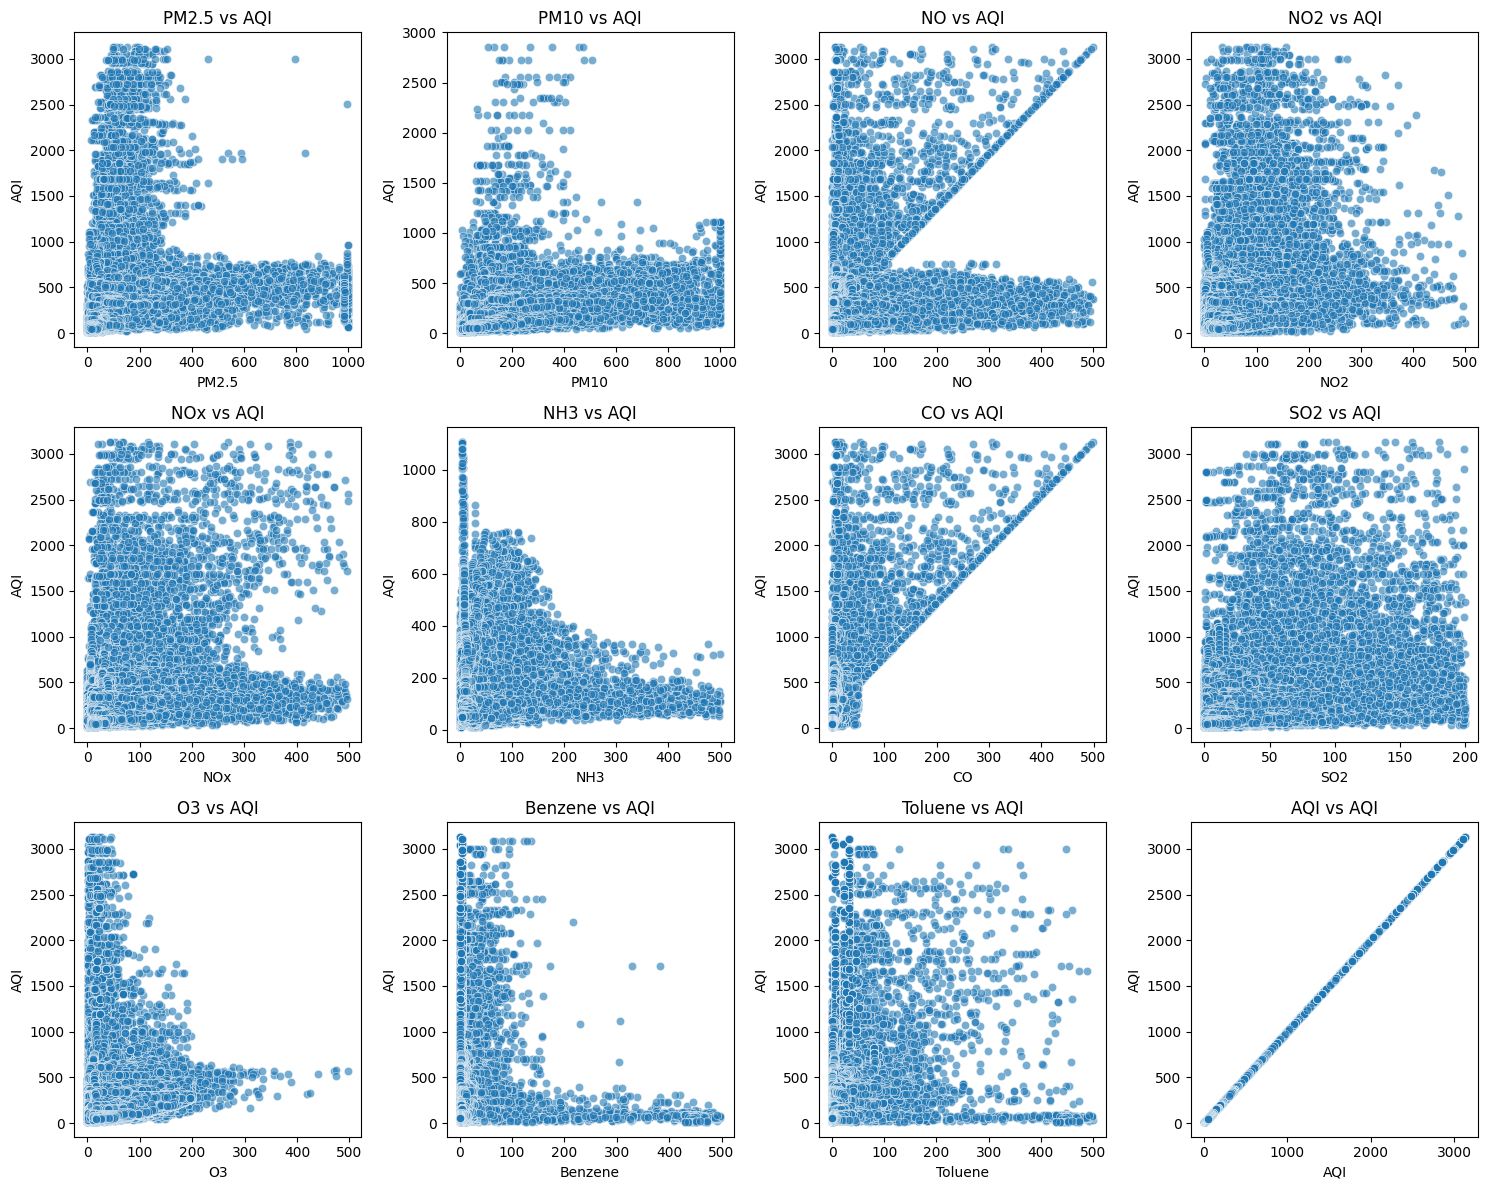

In [58]:
# กำหนดคอลัมน์ที่ต้องการวิเคราะห์
columns_to_visualize = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

# กำหนดจำนวนแถวและคอลัมน์ใน grid layout
n_cols = 4  # จำนวนคอลัมน์ต่อแถว
n_rows = (len(columns_to_visualize) + n_cols - 1) // n_cols  # คำนวณจำนวนแถว

# สร้างกราฟแบบ grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # ขนาดรูปทั้งหมด

# แสดง scatter plot ในแต่ละช่อง
for i, col in enumerate(columns_to_visualize):
    row, col_pos = divmod(i, n_cols)
    sns.scatterplot(data=dataset, x=col, y='AQI', ax=axes[row, col_pos], alpha=0.6)
    axes[row, col_pos].set_title(f'{col} vs AQI')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('AQI')

# ซ่อน axes ที่เหลือ
for j in range(i + 1, n_rows * n_cols):
    row, col_pos = divmod(j, n_cols)
    axes[row, col_pos].axis('off')

plt.tight_layout()
plt.show()

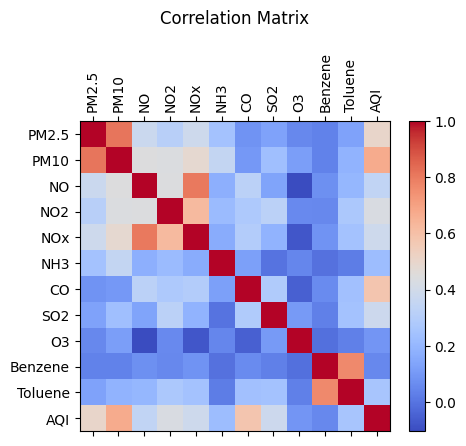

In [59]:
# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข
numerical_dataset = dataset.select_dtypes(include=['float64', 'int64'])

# คำนวณ correlation matrix
correlation_matrix = numerical_dataset.corr()

# แสดงผล correlation matrix ด้วย matshow
plt.figure(figsize=(5, 4))  # ปรับขนาดกราฟให้เหมาะสม
plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')  # เพิ่ม colormap
plt.colorbar()  # เพิ่ม legend แสดงระดับค่า correlation
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix", pad=20)
plt.show()

## แบบยูจีน: Replace Outliers

AQI: Outliers Before = 27389, Outliers After = 0
PM2.5: Outliers Before = 48467, Outliers After = 0
PM10: Outliers Before = 33318, Outliers After = 0
NO: Outliers Before = 65496, Outliers After = 0
NO2: Outliers Before = 35763, Outliers After = 0
NOx: Outliers Before = 45157, Outliers After = 0
NH3: Outliers Before = 26016, Outliers After = 0
CO: Outliers Before = 60434, Outliers After = 0
SO2: Outliers Before = 56198, Outliers After = 0
O3: Outliers Before = 28519, Outliers After = 0
Benzene: Outliers Before = 36001, Outliers After = 0
Toluene: Outliers Before = 61931, Outliers After = 0


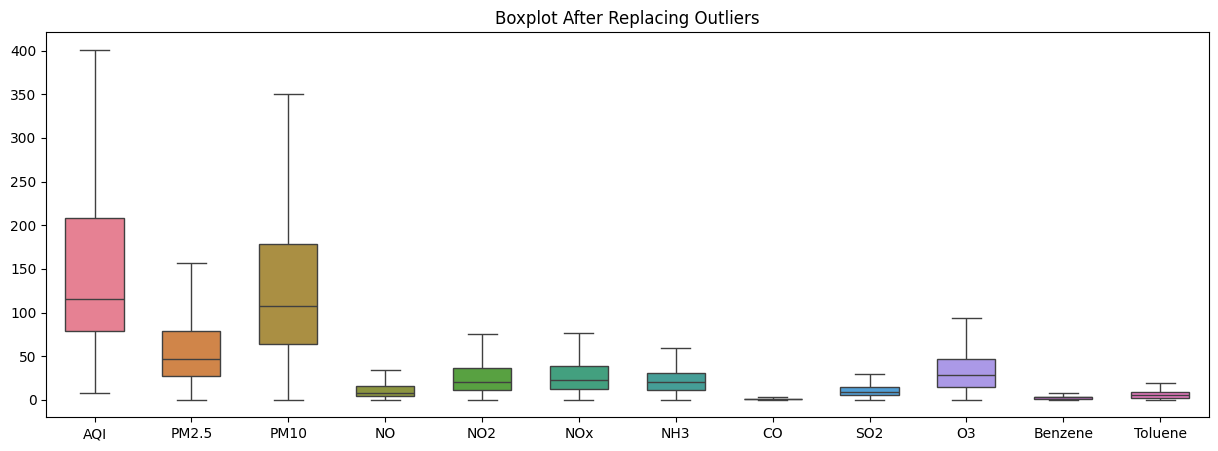

In [78]:
# ฟังก์ชันแทนค่าที่เป็น Outliers ด้วย Q1 หรือ Q3
def replace_outliers_with_quartiles(dataset, columns):
    # สร้างสำเนาของ dataset เพื่อไม่เปลี่ยนแปลงข้อมูลต้นฉบับ
    modified_dataset = dataset.copy()

    for column in columns:
        # คำนวณ Q1, Q3 และ IQR
        Q1 = modified_dataset[column].quantile(0.25)
        Q3 = modified_dataset[column].quantile(0.75)
        IQR = Q3 - Q1

        # คำนวณขอบเขตของ Outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # แทนค่า Outliers ด้วย Q1 หรือ Q3
        modified_dataset[column] = modified_dataset[column].apply(
            lambda x: Q1 if x < lower_bound else (Q3 if x > upper_bound else x)
        )

        # ตรวจสอบจำนวน Outliers ก่อนและหลังการแทน
        num_outliers_before = ((dataset[column] < lower_bound) | (dataset[column] > upper_bound)).sum()
        num_outliers_after = ((modified_dataset[column] < lower_bound) | (modified_dataset[column] > upper_bound)).sum()

        print(f"{column}: Outliers Before = {num_outliers_before}, Outliers After = {num_outliers_after}")

    return modified_dataset

# คอลัมน์ที่ต้องการแทนค่า Outliers
columns_to_analyze = ['AQI','PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

# เรียกใช้ฟังก์ชันกับคอลัมน์ที่เลือก
replaced_dataset = replace_outliers_with_quartiles(filled_dataset_1, columns_to_analyze)

# วาด Boxplot เพื่อแสดงผลหลังการแทนค่า
plt.figure(figsize=(15, 5))
sns.boxplot(data=replaced_dataset[columns_to_analyze], width=0.6)
plt.title("Boxplot After Replacing Outliers")
plt.show()

In [62]:
replaced_dataset.isnull().sum()

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

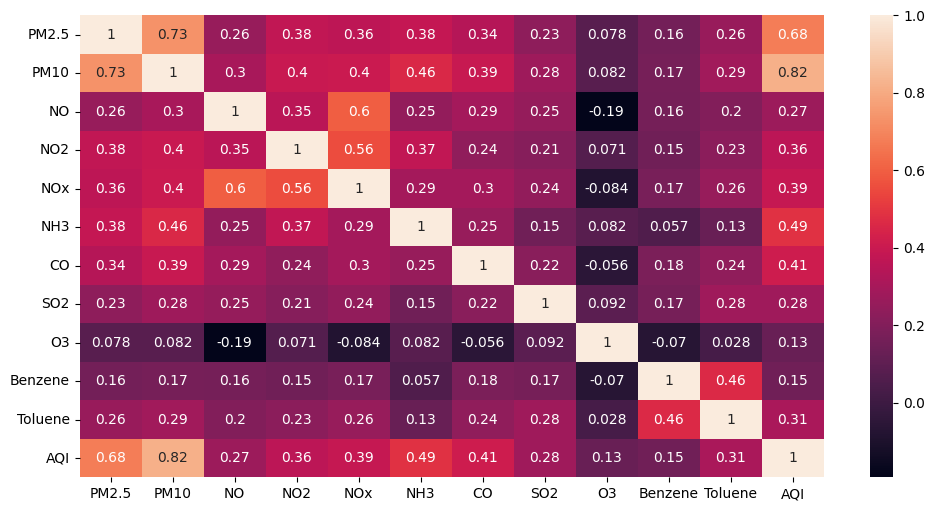

In [79]:
new_replaced_dataset = replaced_dataset.copy()
new_replaced_dataset.drop(columns=['City', 'AQI_Bucket'], inplace=True)
plt.figure(figsize=(12, 6))
sns.heatmap(new_replaced_dataset.corr(),annot=True)
plt.show()

In [64]:
NEW_NEW_replaced_dataset = replaced_dataset.copy()
NEW_NEW_replaced_dataset.drop(columns=['O3','Benzene'])

City  PM2.5        PM10    NO    NO2    NOx        NH3    CO  \
680         Ahmedabad  80.47  198.679653  1.42  21.90  20.65  29.660342  1.42   
681         Ahmedabad  87.80  123.658990  2.03  19.87  22.22  24.654699  2.03   
682         Ahmedabad  90.53  123.658990  1.72  20.11  22.12  24.654699  1.72   
683         Ahmedabad  83.53  123.658990  0.75  16.35  16.48  24.654699  0.75   
684         Ahmedabad  68.40  123.658990  0.58  13.73  12.50  24.654699  0.58   
...               ...    ...         ...   ...    ...    ...        ...   ...   
707870  Visakhapatnam   9.50   36.000000  2.75  25.57  15.85   4.570000  0.62   
707871  Visakhapatnam  17.25   49.250000  3.62  33.20  20.62   3.780000  0.76   
707872  Visakhapatnam  36.00   71.000000  2.20  30.80  18.20   3.670000  0.58   
707873  Visakhapatnam  15.75   63.000000  1.02  28.90  16.00   3.800000  0.49   
707874  Visakhapatnam  15.00   66.000000  0.40  26.85  14.05   5.200000  0.59   

              SO2    Toluene    AQI    AQI_Bucket  
680     14.810000  11.366467  288.0          Poor  
681     14.810000   8.202561  181.0      Moderate  
682     14.810000   8.202561  182.0      Moderate  
683     14.810000   8.202561  182.0      Moderate  
684     14.810000   8.202561  179.0      Moderate  
...           ...        ...    ...           ...  
707870   9.036478   5.993987   51.0  Satisfactory  
707871   2.020000   5.993987   51.0  Satisfactory  
707872   1.770000   4.767300   50.0          Good  
707873   0.750000   4.767300   50.0          Good  
707874   2.100000   4.767300   50.0          Good  

[578795 rows x 12 columns]

# Step 3: Train Model

## Model: Desicion Tree

### filled_dataset_1

Cross-validation scores: [0.85503412 0.85592882 0.85771054 0.85744058 0.85570205]
Mean cross-validation score: 0.8563632230087956
Test accuracy: 0.8608747483996925
Confusion Matrix:


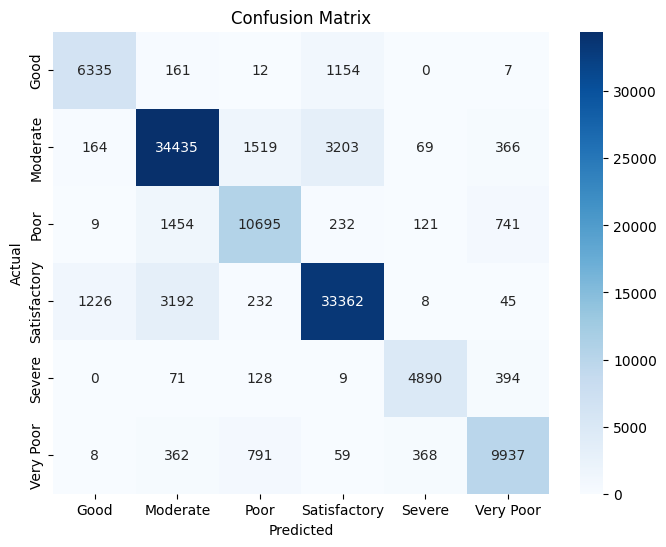

Classification Report:
              precision    recall  f1-score   support

        Good       0.82      0.83      0.82      7669
    Moderate       0.87      0.87      0.87     39756
        Poor       0.80      0.81      0.80     13252
Satisfactory       0.88      0.88      0.88     38065
      Severe       0.90      0.89      0.89      5492
   Very Poor       0.86      0.86      0.86     11525

    accuracy                           0.86    115759
   macro avg       0.85      0.85      0.85    115759
weighted avg       0.86      0.86      0.86    115759



In [65]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_1.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_1['AQI_Bucket']  # target

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

### filled_dataset_1 w/ Z-score

In [66]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_1.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_1['AQI_Bucket']  # target

# Z-score normalization (ทำ normalization ก่อนแบ่งข้อมูล)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Cross-validation scores: [0.85504492 0.8560368  0.85769974 0.85748378 0.85568046]
Mean cross-validation score: 0.8563891389529505
Test accuracy: 0.8607883620280065
Confusion Matrix:


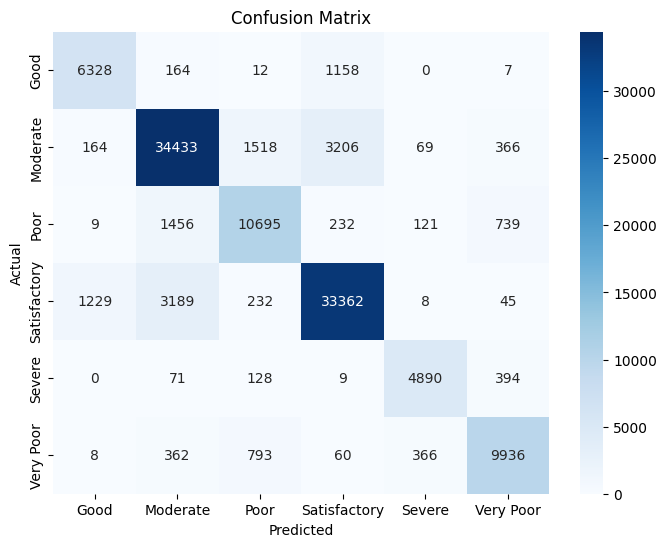

Classification Report:
              precision    recall  f1-score   support

        Good       0.82      0.83      0.82      7669
    Moderate       0.87      0.87      0.87     39756
        Poor       0.80      0.81      0.80     13252
Satisfactory       0.88      0.88      0.88     38065
      Severe       0.90      0.89      0.89      5492
   Very Poor       0.86      0.86      0.86     11525

    accuracy                           0.86    115759
   macro avg       0.85      0.85      0.85    115759
weighted avg       0.86      0.86      0.86    115759



In [67]:
# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ (ในขั้นตอนการเทรน)
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

### filled_dataset_2

Cross-validation scores: [0.85503412 0.85592882 0.85771054 0.85744058 0.85570205]
Mean cross-validation score: 0.8563632230087956
Test accuracy: 0.8608747483996925
Confusion Matrix:


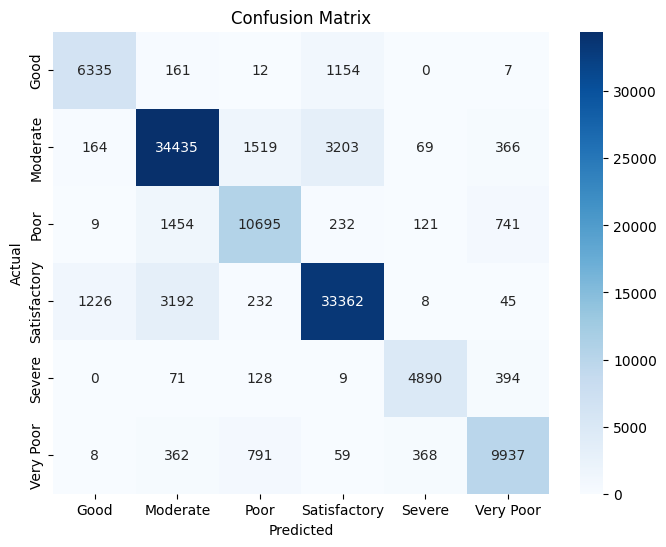

Classification Report:
              precision    recall  f1-score   support

        Good       0.82      0.83      0.82      7669
    Moderate       0.87      0.87      0.87     39756
        Poor       0.80      0.81      0.80     13252
Satisfactory       0.88      0.88      0.88     38065
      Severe       0.90      0.89      0.89      5492
   Very Poor       0.86      0.86      0.86     11525

    accuracy                           0.86    115759
   macro avg       0.85      0.85      0.85    115759
weighted avg       0.86      0.86      0.86    115759



In [68]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_2.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_2['AQI_Bucket']  # target

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

### filled_dataset_3

Cross-validation scores: [0.83634243 0.83653504 0.83554159 0.83728012 0.83413781]
Mean cross-validation score: 0.8359673969733764
Test accuracy: 0.8400556328233658
Confusion Matrix:


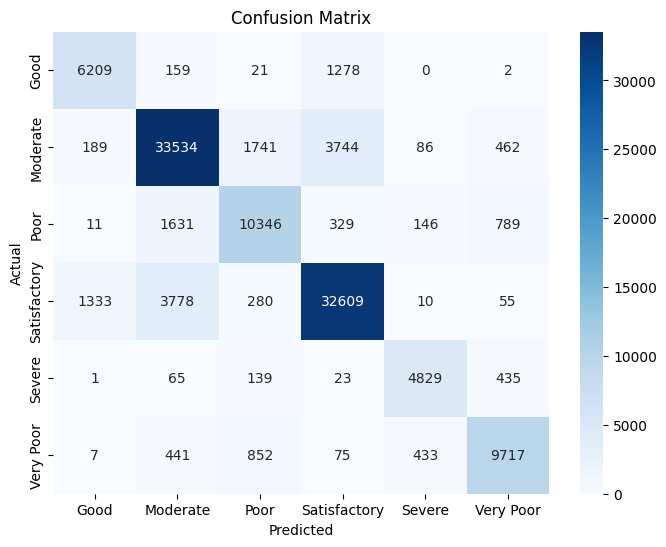

Classification Report:
              precision    recall  f1-score   support

        Good       0.80      0.81      0.81      7669
    Moderate       0.85      0.84      0.85     39756
        Poor       0.77      0.78      0.78     13252
Satisfactory       0.86      0.86      0.86     38065
      Severe       0.88      0.88      0.88      5492
   Very Poor       0.85      0.84      0.85     11525

    accuracy                           0.84    115759
   macro avg       0.83      0.84      0.83    115759
weighted avg       0.84      0.84      0.84    115759



In [69]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_3.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_3['AQI_Bucket']  # target

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

### filled_dataset_4

Cross-validation scores: [0.81720802 0.81931172 0.81841545 0.81762718 0.81677411]
Mean cross-validation score: 0.817867294679632
Test accuracy: 0.8246529427517515
Confusion Matrix:


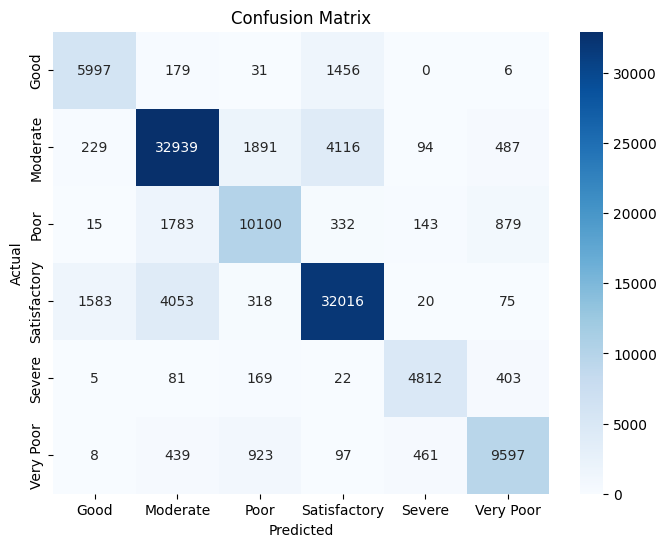

Classification Report:
              precision    recall  f1-score   support

        Good       0.77      0.78      0.77      7669
    Moderate       0.83      0.83      0.83     39756
        Poor       0.75      0.76      0.76     13252
Satisfactory       0.84      0.84      0.84     38065
      Severe       0.87      0.88      0.87      5492
   Very Poor       0.84      0.83      0.84     11525

    accuracy                           0.82    115759
   macro avg       0.82      0.82      0.82    115759
weighted avg       0.82      0.82      0.82    115759



In [70]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_4.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_4['AQI_Bucket']  # target

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

### แบบยูจีน:

Cross-validation scores: [0.84762655 0.84912588 0.8502705  0.84978457 0.84591878]
Mean cross-validation score: 0.8485452554848878
Test accuracy: 0.8525298248948245
Confusion Matrix:


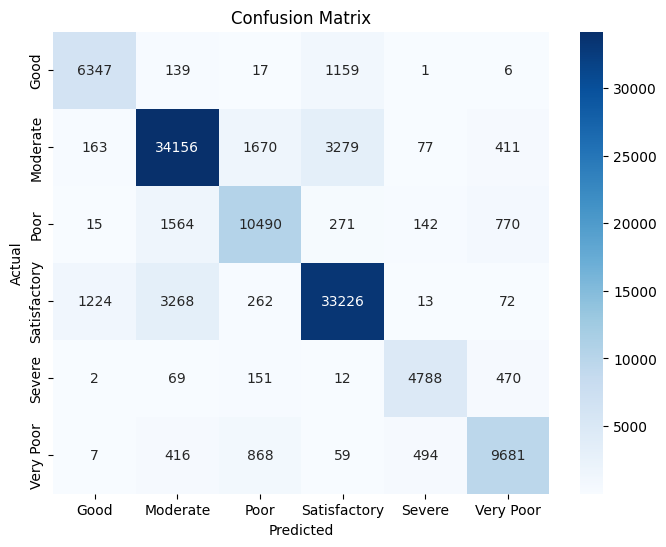

Classification Report:
              precision    recall  f1-score   support

        Good       0.82      0.83      0.82      7669
    Moderate       0.86      0.86      0.86     39756
        Poor       0.78      0.79      0.79     13252
Satisfactory       0.87      0.87      0.87     38065
      Severe       0.87      0.87      0.87      5492
   Very Poor       0.85      0.84      0.84     11525

    accuracy                           0.85    115759
   macro avg       0.84      0.84      0.84    115759
weighted avg       0.85      0.85      0.85    115759



In [80]:
# เตรียมข้อมูล (แยก features และ target)
X = NEW_NEW_replaced_dataset.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = NEW_NEW_replaced_dataset['AQI_Bucket']  # target

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างโมเดล Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
dt_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = dt_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=dt_model.classes_)
print("Classification Report:")
print(report)

## Model: XGBoost

In [72]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

### filled_dataset_1

Cross-validation scores: [0.89828093 0.89849579 0.8991113  0.90128176 0.89806386]
Mean cross-validation score: 0.8990467280423164
Test accuracy: 0.9008802771274804
Confusion Matrix:


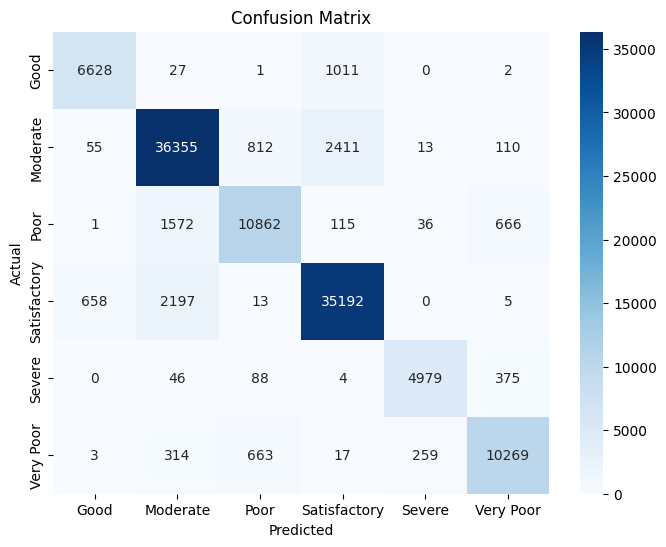

Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.86      0.88      7669
    Moderate       0.90      0.91      0.91     39756
        Poor       0.87      0.82      0.85     13252
Satisfactory       0.91      0.92      0.92     38065
      Severe       0.94      0.91      0.92      5492
   Very Poor       0.90      0.89      0.89     11525

    accuracy                           0.90    115759
   macro avg       0.90      0.89      0.89    115759
weighted avg       0.90      0.90      0.90    115759



In [73]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_1.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_1['AQI_Bucket']  # target

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

## filled_dataset_1 w/ Z-score

In [82]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_1.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_1['AQI_Bucket']  # target

# Z-score normalization (ทำ normalization ก่อนแบ่งข้อมูล)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Cross-validation scores: [0.89828093 0.89849579 0.8991113  0.90128176 0.89806386]
Mean cross-validation score: 0.8990467280423164
Test accuracy: 0.9008802771274804
Confusion Matrix:


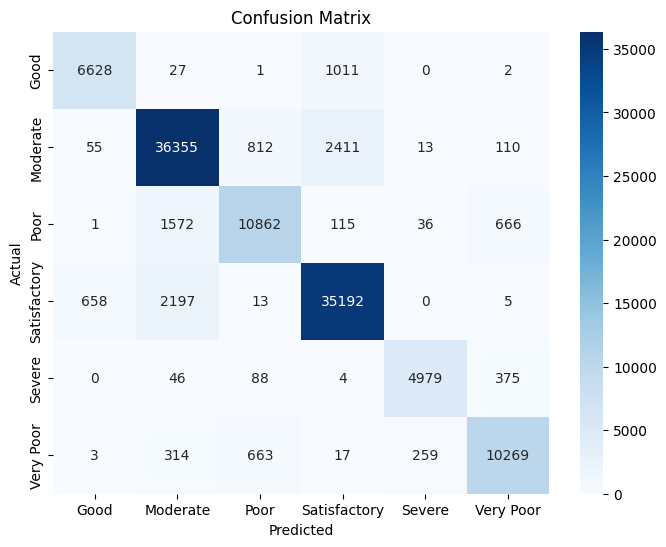

Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.86      0.88      7669
    Moderate       0.90      0.91      0.91     39756
        Poor       0.87      0.82      0.85     13252
Satisfactory       0.91      0.92      0.92     38065
      Severe       0.94      0.91      0.92      5492
   Very Poor       0.90      0.89      0.89     11525

    accuracy                           0.90    115759
   macro avg       0.90      0.89      0.89    115759
weighted avg       0.90      0.90      0.90    115759



In [83]:
# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

### filled_dataset_2

Cross-validation scores: [0.89828093 0.89849579 0.8991113  0.90128176 0.89806386]
Mean cross-validation score: 0.8990467280423164
Test accuracy: 0.9008802771274804
Confusion Matrix:


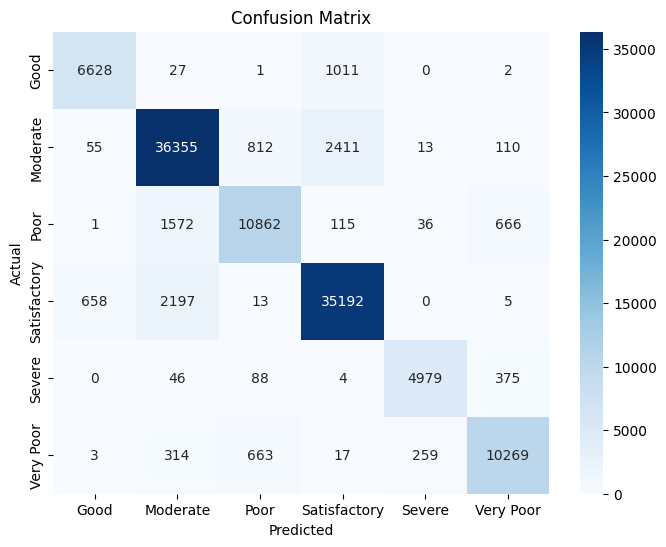

Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.86      0.88      7669
    Moderate       0.90      0.91      0.91     39756
        Poor       0.87      0.82      0.85     13252
Satisfactory       0.91      0.92      0.92     38065
      Severe       0.94      0.91      0.92      5492
   Very Poor       0.90      0.89      0.89     11525

    accuracy                           0.90    115759
   macro avg       0.90      0.89      0.89    115759
weighted avg       0.90      0.90      0.90    115759



In [74]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_2.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_2['AQI_Bucket']  # target

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

### filled_dataset_3

Cross-validation scores: [0.88674845 0.88841016 0.88743831 0.889436   0.88552701]
Mean cross-validation score: 0.8875119877580634
Test accuracy: 0.888527025976382
Confusion Matrix:


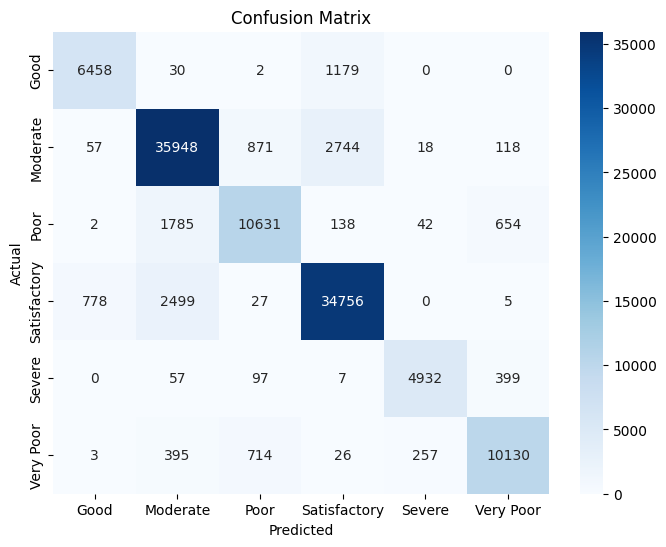

Classification Report:
              precision    recall  f1-score   support

        Good       0.88      0.84      0.86      7669
    Moderate       0.88      0.90      0.89     39756
        Poor       0.86      0.80      0.83     13252
Satisfactory       0.89      0.91      0.90     38065
      Severe       0.94      0.90      0.92      5492
   Very Poor       0.90      0.88      0.89     11525

    accuracy                           0.89    115759
   macro avg       0.89      0.87      0.88    115759
weighted avg       0.89      0.89      0.89    115759



In [75]:
# เตรียมข้อมูล (แยก features และ target)
X = filled_dataset_3.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filled_dataset_3['AQI_Bucket']  # target

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

### filled_dataset_4

Cross-validation scores: [0.90094777 0.90052444 0.90454727 0.90463152 0.90079825]
Mean cross-validation score: 0.9022898504696076
Test accuracy: 0.9038247683235047
Confusion Matrix:


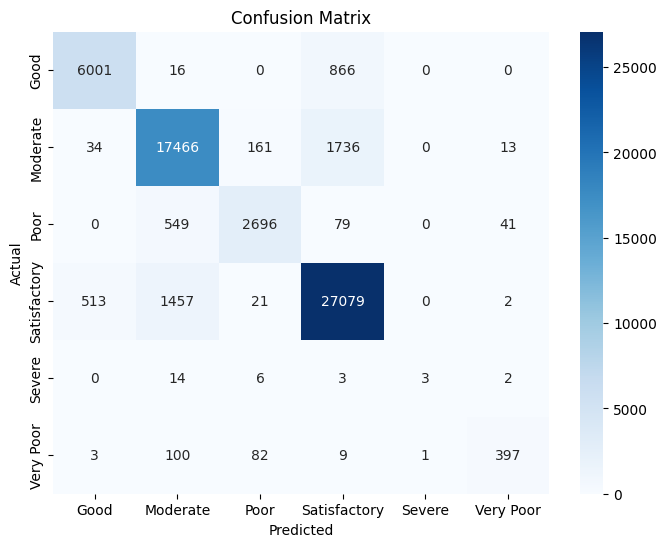

Classification Report:
              precision    recall  f1-score   support

        Good       0.92      0.87      0.89      6883
    Moderate       0.89      0.90      0.90     19410
        Poor       0.91      0.80      0.85      3365
Satisfactory       0.91      0.93      0.92     29072
      Severe       0.75      0.11      0.19        28
   Very Poor       0.87      0.67      0.76       592

    accuracy                           0.90     59350
   macro avg       0.87      0.71      0.75     59350
weighted avg       0.90      0.90      0.90     59350



In [76]:
# เตรียมข้อมูล (แยก features และ target)
X = filtered_dataset.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = filtered_dataset['AQI_Bucket']  # target

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

## แบบยูจีน: Outlier

Cross-validation scores: [0.89445836 0.89359336 0.89359336 0.89684365 0.8939389 ]
Mean cross-validation score: 0.8944855260220889
Test accuracy: 0.8965695971803488
Confusion Matrix:


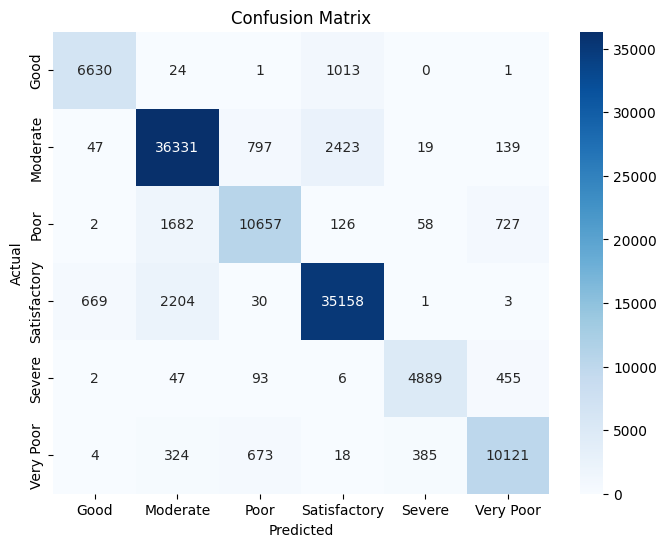

Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.86      0.88      7669
    Moderate       0.89      0.91      0.90     39756
        Poor       0.87      0.80      0.84     13252
Satisfactory       0.91      0.92      0.92     38065
      Severe       0.91      0.89      0.90      5492
   Very Poor       0.88      0.88      0.88     11525

    accuracy                           0.90    115759
   macro avg       0.90      0.88      0.89    115759
weighted avg       0.90      0.90      0.90    115759



In [81]:
# เตรียมข้อมูล (แยก features และ target)
X = NEW_NEW_replaced_dataset.drop(columns=['AQI_Bucket', 'AQI', 'City'])  # features (ลบ 'City' ออก)
y = NEW_NEW_replaced_dataset['AQI_Bucket']  # target

# ใช้ LabelEncoder เพื่อแปลงค่า AQI_Bucket ซึ่งเป็น Class label ของเราให้เป็นตัวเลขก่อน (ไม่งั้นเราจะ train ไม่ได้)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # แปลงเป็นค่าตัวเลข

# แบ่งข้อมูลเป็น train และ test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# สร้างโมเดล XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# ใช้ Cross-Validation เพื่อตรวจสอบประสิทธิภาพ
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # ใช้ 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# ฝึกโมเดลด้วยข้อมูล Train
xgb_model.fit(X_train, y_train)

# ทำนายผลลัพธ์จากข้อมูล Test
y_pred = xgb_model.predict(X_test)

# ประเมินผลจากการทำนาย
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

# วาด Confusion Matrix ให้สวยด้วย Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# คำนวณ Precision, Recall, และ F1-score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)